In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)

2.3.1


In [4]:
import string
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
from keras.backend.tensorflow_backend import set_session
import keras
import sys, time, os, warnings 
warnings.filterwarnings("ignore")
import re

Using TensorFlow backend.


In [5]:
import numpy as np
import pandas as pd 
from PIL import Image
import pickle
from collections import Counter
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle
from keras.applications.vgg16 import VGG16, preprocess_input

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Utility Functions to load and clean data

In [7]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

# To remove punctuations
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)


# To remove single characters
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# To remove numeric values
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

# Exploratory Data Analysis

In [8]:
from os import listdir
## The location of the Flickr8K_ photos
image_dir = 'D:\caaption_dataset\Flicker8k_Dataset'
images = listdir(image_dir)

## The location of the caption file
descriptions_dir = 'D:\caaption_dataset/Flickr8k.token.txt'

print("The number of images in Flicker8k: {}".format(len(images)))

The number of images in Flicker8k: 8091


In [9]:
text = load_doc(descriptions_dir)
print(text[:410])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .


# Making a dataframe

In [10]:
def make_dataset(text):
  df = []
  for sentences in text.split('\n'):
      splitted = sentences.split('\t')
      if len(splitted) == 1:
          continue
      w = splitted[0].split("#")
      df.append(w + [splitted[1].lower()])
  return df

In [11]:
df = make_dataset(text)
df[:15]

[['1000268201_693b08cb0e.jpg',
  '0',
  'a child in a pink dress is climbing up a set of stairs in an entry way .'],
 ['1000268201_693b08cb0e.jpg', '1', 'a girl going into a wooden building .'],
 ['1000268201_693b08cb0e.jpg',
  '2',
  'a little girl climbing into a wooden playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  '3',
  'a little girl climbing the stairs to her playhouse .'],
 ['1000268201_693b08cb0e.jpg',
  '4',
  'a little girl in a pink dress going into a wooden cabin .'],
 ['1001773457_577c3a7d70.jpg',
  '0',
  'a black dog and a spotted dog are fighting'],
 ['1001773457_577c3a7d70.jpg',
  '1',
  'a black dog and a tri-colored dog playing with each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  '2',
  'a black dog and a white dog with brown spots are staring at each other in the street .'],
 ['1001773457_577c3a7d70.jpg',
  '3',
  'two dogs of different breeds looking at each other on the road .'],
 ['1001773457_577c3a7d70.jpg',
  '4',
  'two dogs on pavement moving t

In [12]:
data = pd.DataFrame(df,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...
...,...,...,...
40455,0,997722733_0cb5439472.jpg,a man in a pink shirt climbs a rock face
40456,1,997722733_0cb5439472.jpg,a man is rock climbing high in the air .
40457,2,997722733_0cb5439472.jpg,a person in a red shirt climbing up a rock fac...
40458,3,997722733_0cb5439472.jpg,a rock climber in a red shirt .


# Data Cleaning

In [13]:
def invalid_filename_check(data):
  for filenames in data["filename"]:
    found = re.search("(.(jpg)$)", filenames)
    if (found):
        pass
    else:
        print("Error file: {}".format(filenames))

In [14]:
invalid_filename_check(data)

Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1
Error file: 2258277193_586949ec62.jpg.1


# Removing images that don't have .jgp extension

In [15]:
data[data['filename'] == "2258277193_586949ec62.jpg.1"]

,index,filename,caption
6730,0,2258277193_586949ec62.jpg.1,people waiting for the subway
6731,1,2258277193_586949ec62.jpg.1,some people looking out windows in a large bui...
6732,2,2258277193_586949ec62.jpg.1,three people are waiting on a train platform .
6733,3,2258277193_586949ec62.jpg.1,three people standing at a station .
6734,4,2258277193_586949ec62.jpg.1,two woman and one man standing near train trac...


In [16]:
data = data[data['filename'] != '2258277193_586949ec62.jpg.1']
data.shape

(40455, 3)

# Exploring dataframe

In [17]:
def utility_counter(data):

  unique_filenames = np.unique(data.filename.values)
  print("The number of unique file names : {}".format(len(unique_filenames)))

  ct_dict = Counter(data.filename.values)
  print("We can see that all the keys are having values count = 5")
  print(ct_dict)

  print("The distribution of the number of captions for each image:")
  ct = Counter(Counter(data.filename.values).values())
  print(ct)
  return unique_filenames

In [18]:
unique_filenames = utility_counter(data)

The number of unique file names : 8091
We can see that all the keys are having values count = 5
Counter({'1000268201_693b08cb0e.jpg': 5, '1001773457_577c3a7d70.jpg': 5, '1002674143_1b742ab4b8.jpg': 5, '1003163366_44323f5815.jpg': 5, '1007129816_e794419615.jpg': 5, '1007320043_627395c3d8.jpg': 5, '1009434119_febe49276a.jpg': 5, '1012212859_01547e3f17.jpg': 5, '1015118661_980735411b.jpg': 5, '1015584366_dfcec3c85a.jpg': 5, '101654506_8eb26cfb60.jpg': 5, '101669240_b2d3e7f17b.jpg': 5, '1016887272_03199f49c4.jpg': 5, '1019077836_6fc9b15408.jpg': 5, '1019604187_d087bf9a5f.jpg': 5, '1020651753_06077ec457.jpg': 5, '1022454332_6af2c1449a.jpg': 5, '1022454428_b6b660a67b.jpg': 5, '1022975728_75515238d8.jpg': 5, '102351840_323e3de834.jpg': 5, '1024138940_f1fefbdce1.jpg': 5, '102455176_5f8ead62d5.jpg': 5, '1026685415_0431cbf574.jpg': 5, '1028205764_7e8df9a2ea.jpg': 5, '1030985833_b0902ea560.jpg': 5, '103106960_e8a41d64f8.jpg': 5, '103195344_5d2dc613a3.jpg': 5, '103205630_682ca7285b.jpg': 5, '10321

# Displaying images along with there captions

In [19]:
def image_desc_plotter(data):
  npic = 5
  npix = 224
  target_size = (npix,npix,3)

  count = 1
  fig = plt.figure(figsize=(10,20))
  for jpgfnm in unique_filenames[20:25]:
      filename = image_dir + '/' + jpgfnm
      captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
      image_load = load_img(filename, target_size=target_size)
      
      ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
      ax.imshow(image_load)
      count += 1
      
      ax = fig.add_subplot(npic,2,count)
      plt.axis('off')
      ax.plot()
      ax.set_xlim(0,1)
      ax.set_ylim(0,len(captions))
      for i, caption in enumerate(captions):
          ax.text(0,i,caption,fontsize=20)
      count += 1
  plt.show()

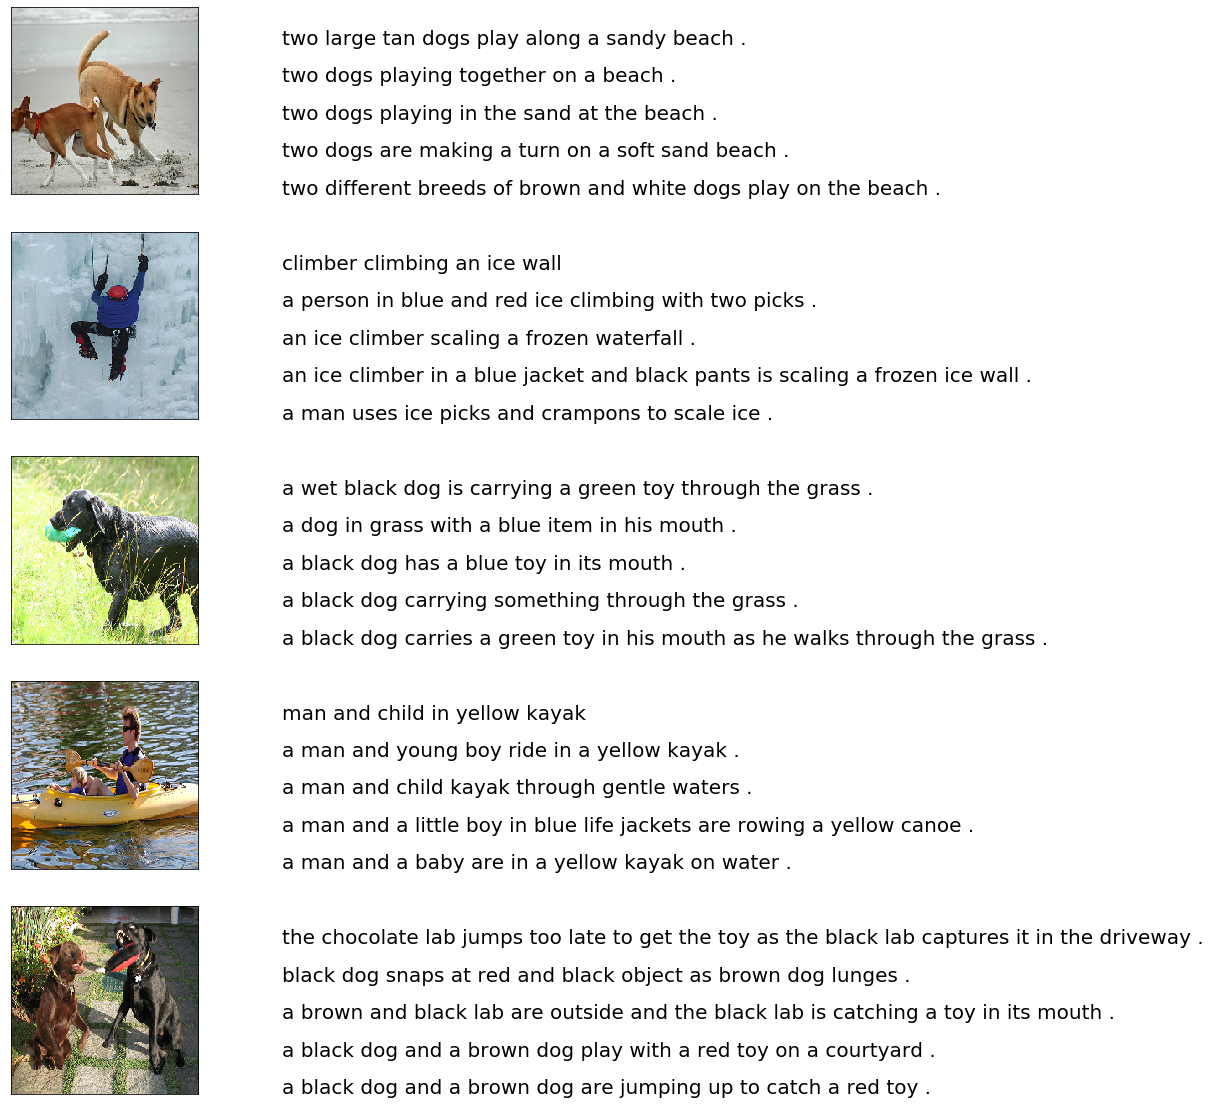

In [20]:
image_desc_plotter(data)

# Preprocessing images and captions

In [21]:
def create_vocabulary(data):
  vocab = []
  for captions in data.caption.values:
    vocab.extend(captions.split())
  print("Size of vocabulary is : {}".format(len(set(vocab))))
  return vocab

In [22]:
vocabulary = create_vocabulary(data)

Size of vocabulary is : 8918


In [23]:
def df_word_count(data,vocabulary):
    ct = Counter(vocabulary)
    appen_1 = []
    appen_2 = []
    for i in ct.keys():
        appen_1.append(i)
    for j in ct.values():
        appen_2.append(j)
    data = {"word":appen_1 , "count":appen_2}
    dfword = pd.DataFrame(data)
    dfword = dfword.sort_values(by='count', ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

In [24]:
dfwordcount = df_word_count(data,vocabulary)

In [25]:
dfwordcount.iloc[:15,:]

,word,count
0,a,62986
1,.,36577
2,in,18974
3,the,18418
4,on,10743
5,is,9345
6,and,8851
7,dog,8136
8,with,7765
9,man,7265


# Finding top 30 most and least frequently appearing word in captions

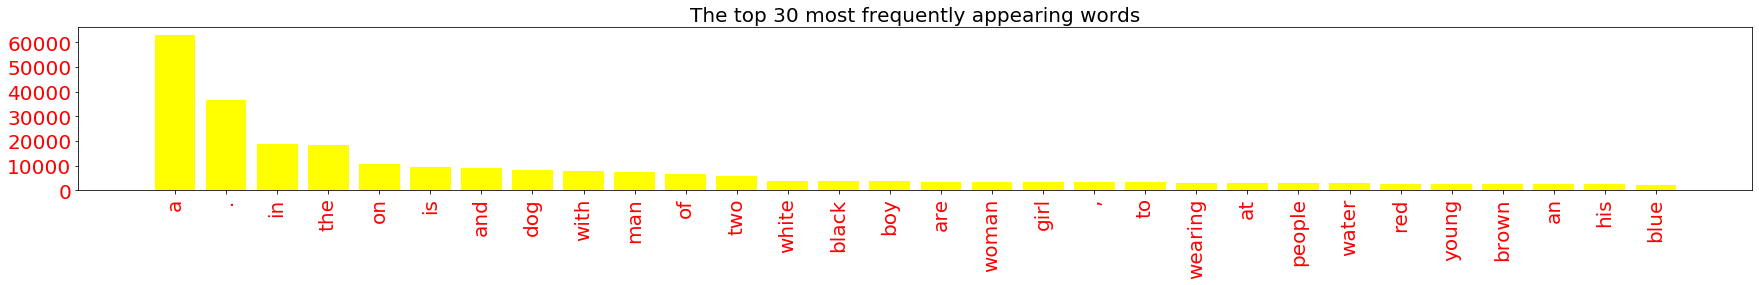

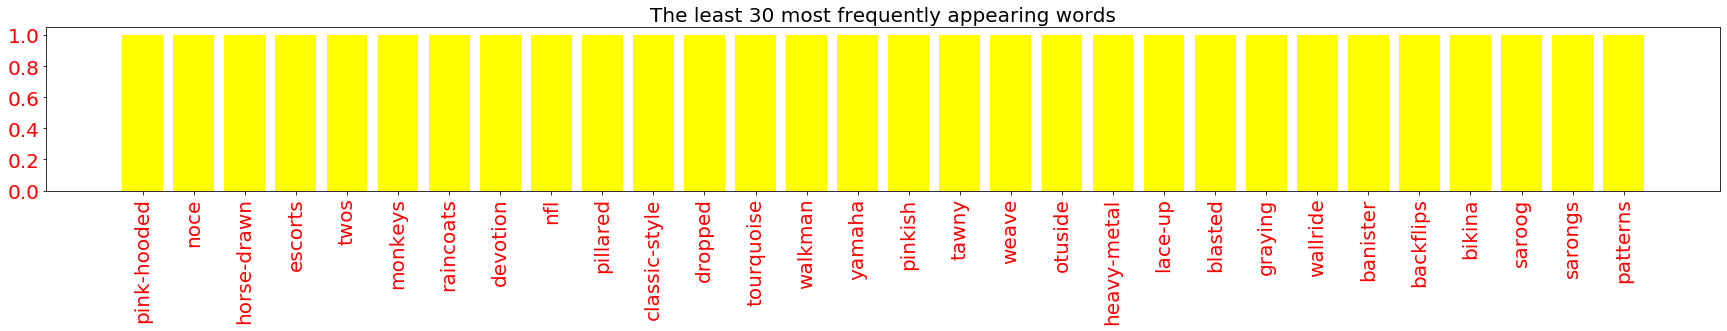

In [26]:
topn = 30

def plthist(dfsub, title="The top 30 most frequently appearing words"):
    plt.figure(figsize=(30,3))
    plt.bar(dfsub.index,dfsub["count"],color ='yellow')
    plt.yticks(fontsize=20,color ='r')
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20,color ='r')
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfwordcount.iloc[:topn,:],
        title="The top 30 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 30 most frequently appearing words")

# Cleaning captions

In [27]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)
    
for i, caption in enumerate(data.caption.values):
    newcaption = text_clean(caption)
    data["caption"].iloc[i] = newcaption

In [28]:
clean_vocabulary = create_vocabulary(data)

Size of vocabulary is : 8357


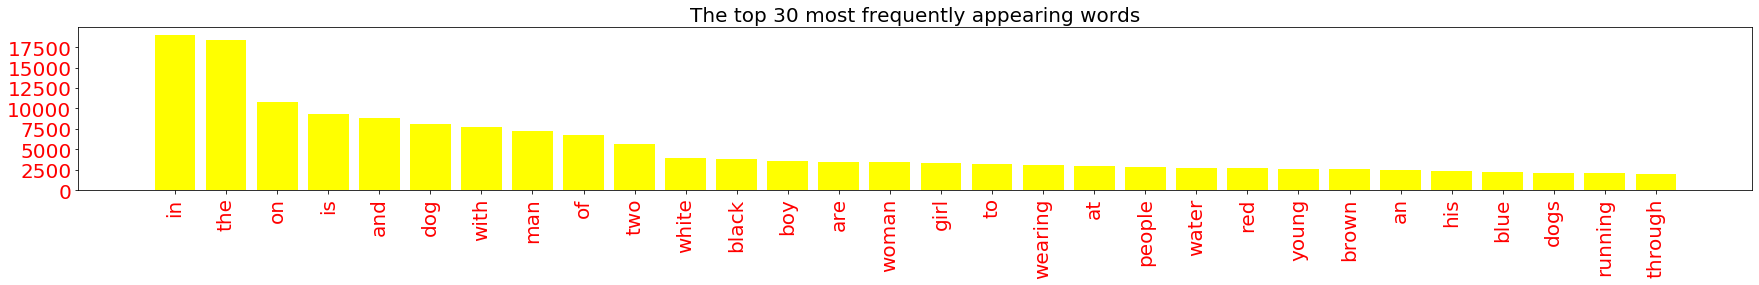

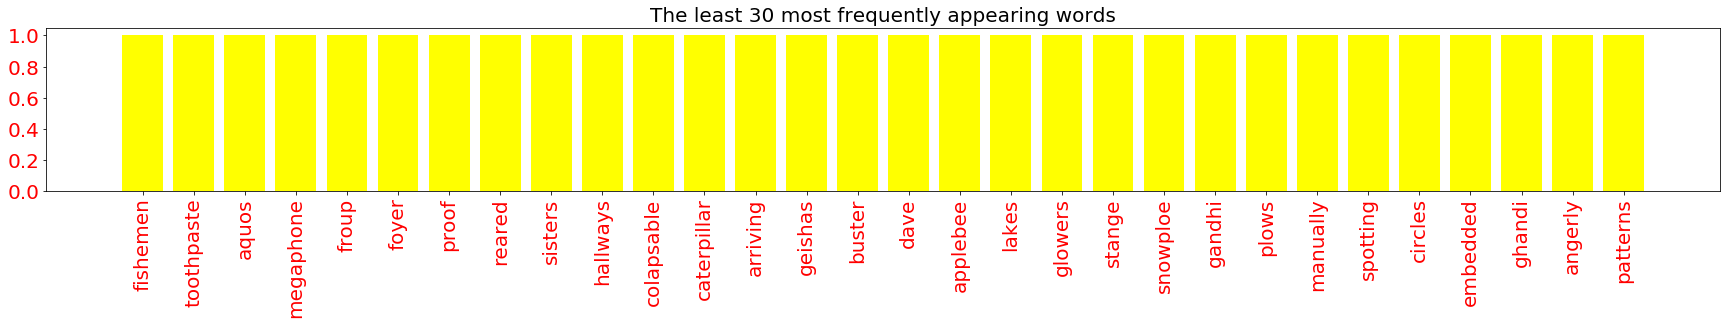

In [29]:
dfwordcount = df_word_count(data,clean_vocabulary)
plthist(dfwordcount.iloc[:topn,:],
        title="The top 30 most frequently appearing words")
plthist(dfwordcount.iloc[-topn:,:],
        title="The least 30 most frequently appearing words")

# Image Prepeocessing 

In [30]:
def preprocess_images(data):
  all_img_name_vector = []

  for filenames in data["filename"]:
      full_image_path = image_dir+"/"+ filenames
      all_img_name_vector.append(full_image_path)
  return all_img_name_vector
all_img_name_vector = preprocess_images(data)
all_img_name_vector[:10]

['D:\\caaption_dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'D:\\caaption_dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'D:\\caaption_dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'D:\\caaption_dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'D:\\caaption_dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 'D:\\caaption_dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'D:\\caaption_dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'D:\\caaption_dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'D:\\caaption_dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 'D:\\caaption_dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg']

# Adding  (start) and (end) tag to each captions

In [31]:
def preprocess_captions(data):
  total_captions = []

  for caption  in data["caption"].astype(str):
      caption = '<start> ' + caption+ ' <end>'
      total_captions.append(caption)
  return total_captions
total_captions = preprocess_captions(data)
total_captions[:15]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>',
 '<start>  little girl covered in paint sits in front of painted rainbow with her hands in bowl <end>',
 '<start>  little girl is sitting in front of large painted rainbow <end>',
 '<start>  small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it <end>

In [32]:
ten_images = all_img_name_vector[:50] # Each image repeats 5 times in dataset
unique_images = np.unique(ten_images)
print(unique_images)

['D:\\caaption_dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
 'D:\\caaption_dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg'
 'D:\\caaption_dataset\\Flicker8k_Dataset/1002674143_1b742ab4b8.jpg'
 'D:\\caaption_dataset\\Flicker8k_Dataset/1003163366_44323f5815.jpg'
 'D:\\caaption_dataset\\Flicker8k_Dataset/1007129816_e794419615.jpg'
 'D:\\caaption_dataset\\Flicker8k_Dataset/1007320043_627395c3d8.jpg'
 'D:\\caaption_dataset\\Flicker8k_Dataset/1009434119_febe49276a.jpg'
 'D:\\caaption_dataset\\Flicker8k_Dataset/1012212859_01547e3f17.jpg'
 'D:\\caaption_dataset\\Flicker8k_Dataset/1015118661_980735411b.jpg'
 'D:\\caaption_dataset\\Flicker8k_Dataset/1015584366_dfcec3c85a.jpg']


In [33]:
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread

def showImagesHorizontally(ten_images):
    fig = figure()
    number_of_files = len(ten_images)
    for i in range(number_of_files):
        a=fig.add_subplot(1,number_of_files,i+1)
        image = imread(ten_images[i])
        imshow(image,cmap='Greys_r', aspect='equal', interpolation='nearest')
        axis('off')

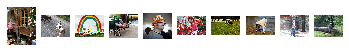

In [34]:
showImagesHorizontally(unique_images)

In [92]:
print("Total Images : " + str(len(all_img_name_vector)))
print("Total Captions : " + str(len(total_captions)))

Total Images : 40455
Total Captions : 40455


# Taking batch size=64 hence we will have 625 batches

In [35]:
def data_limiter(num,total_captions,all_img_name_vector):
  # Shuffle captions and image_names together
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

In [36]:
train_captions,img_name_vector = data_limiter(40000,total_captions,all_img_name_vector)

In [38]:
print("Total Captions are : {0} , Total images are: {1}".format(len(train_captions),len(img_name_vector)))

Total Captions are : 40000 , Total images are: 40000


# Saving varable in .pkl file(pickle file)

In [39]:
from pickle import dump
# save to file
dump(train_captions, open('captions.pkl', 'wb'))
dump(img_name_vector, open('img_names.pkl', 'wb'))

In [40]:
train_captions = load(open('captions.pkl', 'rb'))
img_name_vector = load(open('img_names.pkl', 'rb'))

In [41]:
print("Total Captions are:  {0} , Total images are: {1}".format(len(train_captions),len(img_name_vector)))

Total Captions are:  40000 , Total images are: 40000


# For VGG 16 every image shape need to be 224x224x223

In [42]:
# To know the shape of images
def img_shape_finder(image):
  img= plt.imread(image)

  print("Shape of the image ==> {0} is ==> {1}".format(image.split('/')[1],img.shape))

In [43]:
img_list=[]
for i in range(20):
  img_list.append(img_name_vector[i])

In [44]:
for j in img_list:
  img_shape_finder(j)

Shape of the image ==> 1956678973_223cb1b847.jpg is ==> (500, 375, 3)
Shape of the image ==> 3256603992_67312b5a36.jpg is ==> (375, 500, 3)
Shape of the image ==> 2938747424_64e64784f0.jpg is ==> (375, 500, 3)
Shape of the image ==> 2831314869_5025300133.jpg is ==> (400, 500, 3)
Shape of the image ==> 516725192_c9cdd63878.jpg is ==> (274, 500, 3)
Shape of the image ==> 537559285_29be110134.jpg is ==> (375, 500, 3)
Shape of the image ==> 2172493537_128bc8b187.jpg is ==> (334, 500, 3)
Shape of the image ==> 2287023569_fd7a9c60b8.jpg is ==> (500, 354, 3)
Shape of the image ==> 3191805046_77c334b506.jpg is ==> (500, 333, 3)
Shape of the image ==> 2869491449_1041485a6b.jpg is ==> (350, 500, 3)
Shape of the image ==> 140377584_12bdbdf2f8.jpg is ==> (375, 500, 3)
Shape of the image ==> 132489044_3be606baf7.jpg is ==> (375, 500, 3)
Shape of the image ==> 2346401538_f5e8da66fc.jpg is ==> (322, 500, 3)
Shape of the image ==> 181157221_e12410ef0b.jpg is ==> (375, 500, 3)
Shape of the image ==> 31

Shape of the image:(333, 500, 3)


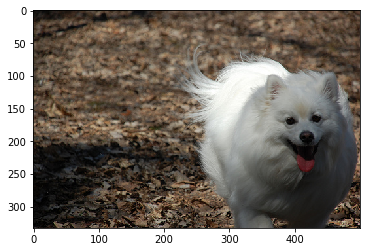

In [46]:
def image_and_shapes(image):
  img= plt.imread(image)
  plt.imshow(img)
  print("Shape of the image:{}".format(img.shape))

image_and_shapes("D:\caaption_dataset\Flicker8k_Dataset/3439243433_d5f3508612.jpg")

# Image Augmentation 

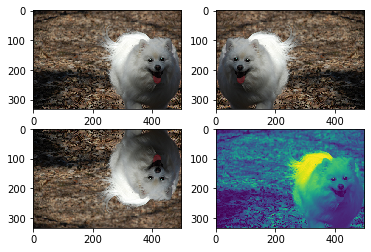

In [49]:
import imageio
def image_flipper(image):
  original_img = imageio.imread(image)
  
  plt.figure(1)

#Original Image

  plt.subplot(221)
  plt.imshow(original_img)

#Left-Right flip Image

  flipped_img_tensor = tf.image.flip_left_right(original_img)
  flipped_img= flipped_img_tensor.numpy()
  plt.subplot(222)
  plt.imshow(flipped_img)

#Up-Down flip Image

  upside_down_flip_tensor = tf.image.flip_up_down(original_img)
  upside_down_flip= upside_down_flip_tensor.numpy()
  plt.subplot(223)
  plt.imshow(upside_down_flip)

#Gray scale Image

  gray_tensor = tf.image.rgb_to_grayscale(original_img)
  grayimg= gray_tensor.numpy()
  plt.subplot(224)
  plt.imshow(tf.squeeze(grayimg))

  #plt.imsave('doggo.jpg',flipped_img)

image_flipper("D:\caaption_dataset\Flicker8k_Dataset/3439243433_d5f3508612.jpg")


# Resizing the images

In [51]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))
    img = preprocess_input(img)
    return img, image_path

img1,img1_path = load_image("D:\caaption_dataset\Flicker8k_Dataset/3439243433_d5f3508612.jpg")
print("Shape after resize :", img1.shape)
#plt.imshow(img1)

Shape after resize : (224, 224, 3)


# Pre trained VGG 16 model 
The VGG16 model was pre-trained on the ImageNet data-set for classifying images. The VGG16 model contains a convolutional part and a fully-connected part which is used for the image classification.

In [52]:
import tensorflow as tf
modelvgg = tf.keras.applications.VGG16(include_top=True,weights=None) # for observation on shapes

In [53]:
modelvgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [54]:
image_model = tf.keras.applications.VGG16(include_top=False,weights='imagenet')
new_input = image_model.input # Any arbitrary shapes with 3 channels
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58892288/58889256 [==============================] - 17s 0us/step


In [55]:
image_features_extract_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

#  Using VGG16 feature extraction

In [56]:
# Get unique images
encode_train = sorted(set(img_name_vector))
print(encode_train[:10])

['D:\\caaption_dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg', 'D:\\caaption_dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg', 'D:\\caaption_dataset\\Flicker8k_Dataset/1002674143_1b742ab4b8.jpg', 'D:\\caaption_dataset\\Flicker8k_Dataset/1003163366_44323f5815.jpg', 'D:\\caaption_dataset\\Flicker8k_Dataset/1007129816_e794419615.jpg', 'D:\\caaption_dataset\\Flicker8k_Dataset/1007320043_627395c3d8.jpg', 'D:\\caaption_dataset\\Flicker8k_Dataset/1009434119_febe49276a.jpg', 'D:\\caaption_dataset\\Flicker8k_Dataset/1012212859_01547e3f17.jpg', 'D:\\caaption_dataset\\Flicker8k_Dataset/1015118661_980735411b.jpg', 'D:\\caaption_dataset\\Flicker8k_Dataset/1015584366_dfcec3c85a.jpg']


In [57]:
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
for files in image_dataset: 
    print(files.numpy())

b'D:\\caaption_dataset\\Flicker8k_Dataset/1000268201_693b08cb0e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1001773457_577c3a7d70.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1002674143_1b742ab4b8.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1003163366_44323f5815.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1007129816_e794419615.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1007320043_627395c3d8.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1009434119_febe49276a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1012212859_01547e3f17.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1015118661_980735411b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1015584366_dfcec3c85a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/101654506_8eb26cfb60.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/101669240_b2d3e7f17b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1016887272_03199f49c4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1019077836_6fc9b15408.jpg'
b'D:\\caaption_dataset\\Flicker8k_Da

b'D:\\caaption_dataset\\Flicker8k_Dataset/1248953128_24c9f8d924.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/124972799_de706b6d0b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1251558317_4ef844b775.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1252396628_eb81d3905b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1252787177_4b08625897.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/125319704_49ead3463c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1253264731_e7c689eca5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1253275679_e955fb7304.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1255504166_f2437febcb.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1258913059_07c613f7ff.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1259936608_e3f0064f23.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1260816604_570fc35836.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1262077938_8b9516c273.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1262454669_f1caafec2d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Da

b'D:\\caaption_dataset\\Flicker8k_Dataset/1440024115_129212c988.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1443807993_aebfb2784a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1445123245_c7b9db0e0c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1445754124_647168f211.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1446053356_a924b4893f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1446933195_8fe9725d62.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1448511770_1a4a9c453b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1449370354_380c4123c9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1449625950_fc9a8d02d9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1449692616_60507875fb.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1452361926_6d8c535e32.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1453366750_6e8cf601bf.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1454678644_7e5a371301.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1454841725_4b6e6199e2.jpg'
b'D:\\caaption_dataset\\Flicker8k_

b'D:\\caaption_dataset\\Flicker8k_Dataset/1858963639_4588cd4be9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/185972340_781d60ccfd.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1859726819_9a793b3b44.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1859941832_7faf6e5fa9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1860543210_47e94cf652.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/186346360_541047336f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/186348874_75b2cf1ec5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1865794069_6e3a1e57bb.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/186890601_8a6b0f1769.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/186890605_ddff5b694e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1874617189_e85d3f4326.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1876536922_8fdf8d7028.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1881494074_1bebd93089.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/1884065356_c6c34b4568.jpg'
b'D:\\caaption_dataset\\Flicker8k_Datas

b'D:\\caaption_dataset\\Flicker8k_Dataset/2114739371_83aa8bdb0e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2115620856_4fa5025ac6.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2115631346_9585a479b0.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2115849046_2aa9fa8d13.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2116316160_d5fa7abdc3.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2116444946_1f5d1fe5d1.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2119302248_72493d458c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2119660490_ce0d4d1f73.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/211981411_e88b8043c2.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2120383553_5825333a3f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2120411340_104eb610b1.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2120469056_7a738413be.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2120571547_05cd56de85.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2121140070_a09644550b.jpg'
b'D:\\caaption_dataset\\Flicker8k_D

b'D:\\caaption_dataset\\Flicker8k_Dataset/2257798999_d9d1b9a45a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2258662398_2797d0eca8.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2258951972_92763fddab.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/225909073_25c3c33a29.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2259203920_6b93b721ce.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2259336826_0cb294e1f7.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2260369648_e21ae6494a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2260560631_09093be4c6.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2260649048_ae45d17e68.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2261169495_98254e2e66.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2261257940_449b6e6c91.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2261346505_302c67951d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2261550615_b6c25d987b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2261962622_e9318a95eb.jpg'
b'D:\\caaption_dataset\\Flicker8k_D

b'D:\\caaption_dataset\\Flicker8k_Dataset/2369840118_a1c4240ab7.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2370221025_be4d9a4431.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2370481277_a3085614c9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2371749487_d80195a2e7.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2371809188_b805497cba.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2372572028_53b76104a9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2372763106_ddea79d36e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/237277765_9e6fa5b99a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2373234213_4ebe9c4ee5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2374179071_af22170d62.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2374247382_023a86b9ca.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2374570771_c395fc224a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2374652725_32f90fa15c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/237547381_aa17c805e0.jpg'
b'D:\\caaption_dataset\\Flicker8k_Da

b'D:\\caaption_dataset\\Flicker8k_Dataset/2447289477_e888df561d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/244760289_f4467b2b67.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/244760301_5809214866.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/244774022_a12c07afdb.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2447972568_1e9b287691.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2448210587_9fe7ea5f42.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2448270671_5e0e391a80.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2448393373_80c011d301.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/244867897_d00369a779.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/244870123_dcb6e53643.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2448793019_5881c025f9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/244910130_e1f823a28a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/244910177_7c4ec3f65b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2449289139_08fc1092c1.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset

b'D:\\caaption_dataset\\Flicker8k_Dataset/2542415282_9240e1b5fc.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2542662402_d781dd7f7c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/254295381_d98fa049f4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2543017787_9720b4fa1c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2543247940_083f1b7969.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2543589122_ec3e55f434.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2543679402_9359e1ee4e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2544182005_3aa1332bf9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2544246151_727427ee07.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2544426580_317b1f1f73.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/254475194_3d8f4dfd53.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2545192257_142fe9e2de.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/254527963_3f5824b0e8.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2545363449_1985903f82.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dat

b'D:\\caaption_dataset\\Flicker8k_Dataset/2635023078_6dae04758f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2635164923_2a774f7854.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/263522013_d118d46b2d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2635400219_2e1a984fd3.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2635483351_bc1a8273aa.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2635905544_dbc65d0622.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2635908229_b9fc90d3fb.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2635938723_11b85e6763.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2636514498_01fcc5f501.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2636876892_9353521a1c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2637510448_4521cf6f29.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2637904605_fc355816fc.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2637959357_dd64a03efa.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2638369467_8fc251595b.jpg'
b'D:\\caaption_dataset\\Flicker8k_D

b'D:\\caaption_dataset\\Flicker8k_Dataset/272156850_c4445a53f4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2721656220_5f4cda8bc1.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/272283076_2d4aa1d5cf.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2723477522_d89f5ac62b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2723929323_70b93a74ea.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2724485630_7d2452df00.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/272546805_536c719648.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2726262796_03bd63a155.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2726301121_95a2fbd22b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2727051596_be65bfb3d3.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2728276857_3f83757ef2.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2728486640_cc2a31d2b0.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2728813605_cfc943e1ab.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2729147877_c3ec3445bf.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dat

b'D:\\caaption_dataset\\Flicker8k_Dataset/2844846111_8c1cbfc75d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2844963839_ff09cdb81f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2845246160_d0d1bbd6f0.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2845691057_d4ab89d889.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2845845721_d0bc113ff7.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2846037553_1a1de50709.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2846785268_904c5fcf9f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2846843520_b0e6211478.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2847514745_9a35493023.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2847615962_c330bded6e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2847859796_4d9cb0d31f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2848266893_9693c66275.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2848571082_26454cb981.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2848895544_6d06210e9d.jpg'
b'D:\\caaption_dataset\\Flicker8k_

b'D:\\caaption_dataset\\Flicker8k_Dataset/2911658792_6a6ef07e3a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2911919938_6bb6587a36.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2911928620_06c3fa293e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2912476706_9a0dbd3a67.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2913207978_9e9624e249.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2913818905_8e4d9aa82a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2913965136_2d00136697.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2913972180_547783dd3d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2914206497_5e36ac6324.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2914331767_8574e7703d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2914737181_0c8e052da8.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2914800692_0c512d27b8.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2915183095_4ed4aa4f37.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/2915538325_59e11276dd.jpg'
b'D:\\caaption_dataset\\Flicker8k_

b'D:\\caaption_dataset\\Flicker8k_Dataset/3006093003_c211737232.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3006094603_c5b32d2758.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3006095077_1992b677f8.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3006217970_90b42e6b27.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3006926228_cf3c067b3e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3007214949_a4b027f8a3.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/300765528_8c8f709dda.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3008370541_ce29ce49f0.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3009018821_ba47396e24.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3009035153_715e39b440.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3009047603_28612247d2.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/300922408_05a4f9938c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3009383694_e045c6169e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3009644534_992e9ea2a7.jpg'
b'D:\\caaption_dataset\\Flicker8k_Da

b'D:\\caaption_dataset\\Flicker8k_Dataset/3091382602_60b9b53ed1.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3091580843_178042c50b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3091594712_2166604334.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3091912922_0d6ebc8f6a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3091916691_b1c96669c6.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3091921457_83eee69591.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3091962081_194f2f3bd4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3092200805_dd1f83ddbe.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3092370204_029b6bc10a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/309238565_2d5d8dc8bf.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3092756650_557c5f2d03.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3093970461_825b0cac2f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3093971101_543237971d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3094064787_aed1666fc9.jpg'
b'D:\\caaption_dataset\\Flicker8k_D

b'D:\\caaption_dataset\\Flicker8k_Dataset/3162289423_4ca8915d0c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3162442331_c9711857c6.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3163068926_d28ed3ef53.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3163198309_bbfe504f0a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3163273640_8d3ef22eaf.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3163281186_e2f43dfb5f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3163323414_d1ce127aa6.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3163477256_073605e06e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3163563871_cef3cf33ea.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3164328039_2c56acf594.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3164347907_2813f8ff0b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3164415865_612f9fd8bc.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3164423279_9b27cb6a06.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3165123595_8db9f918bf.jpg'
b'D:\\caaption_dataset\\Flicker8k_

b'D:\\caaption_dataset\\Flicker8k_Dataset/3209564153_077ed4d246.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3209620285_edfc479392.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3209966887_5b744bd050.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3210359094_ee51285301.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3210419174_d083a16f77.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3210457502_c6030ce567.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3210705660_2b14b7fb36.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3211029717_2affe6bbd5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3211199368_ca78387f72.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3211210739_3dea005fde.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3211289105_e0360a9c7f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3211316116_a2462e327d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3211437611_bd4af3730b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3211453055_05cbfe37cd.jpg'
b'D:\\caaption_dataset\\Flicker8k_

b'D:\\caaption_dataset\\Flicker8k_Dataset/3259992638_0612a40288.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3259992722_4c5e895734.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3260088697_af9b6d2393.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3260191163_6c1551eee8.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3260214530_7179346407.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/326028454_fb396167e6.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3260768565_2b725be090.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3260975858_75d0612a69.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3261493263_381a4c5cc7.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3261666285_86fceb762d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3262075846_5695021d84.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3262301835_9f1a49b80a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3262386960_14f5d857db.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3262475923_f1f77fcd9f.jpg'
b'D:\\caaption_dataset\\Flicker8k_D

b'D:\\caaption_dataset\\Flicker8k_Dataset/3315110972_1090d11728.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3315250232_83e24a2d51.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3315323307_bd148a8964.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3315353266_70f0bbb1c3.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3315616181_15dd137e27.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3315726723_64c9b0a945.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3316046339_8e504be038.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3316725440_9ccd9b5417.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3317073508_7e13565c1b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3317145805_071b15debb.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3317333893_9d0faa8d30.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3317960829_78bbfafbb6.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3318564834_4ccea90497.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3318995586_c2bc50b92e.jpg'
b'D:\\caaption_dataset\\Flicker8k_

b'D:\\caaption_dataset\\Flicker8k_Dataset/3354489242_dd529ffa1f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3354883962_170d19bfe4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3355494822_61353a224d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3355683198_715fb1a2ac.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3355756569_b430a29c2a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3355827928_c96c0c3e88.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/335588286_f67ed8c9f9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3356284586_21c6f155a5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3356369156_074750c6cc.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3356494271_6103d0b556.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3356642567_f1d92cb81b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3356700488_183566145b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3356748019_2251399314.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3356901257_83811a19eb.jpg'
b'D:\\caaption_dataset\\Flicker8k_D

b'D:\\caaption_dataset\\Flicker8k_Dataset/3396036947_0af6c3aab7.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3396043950_12783c5147.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3396153660_f729d9f9b9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3396157719_6807d52a81.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3396251819_1efa69310f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3396275223_ee080df8b5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/339658315_fbb178c252.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3396817186_b299ee0531.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3397220683_4aca010f86.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3397228832_8ce5b1c26f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3397259310_1ed1a346b5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3397310901_cbef5c06ef.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3397633339_d1ae6d9a0e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3397803103_8a46d716f4.jpg'
b'D:\\caaption_dataset\\Flicker8k_D

b'D:\\caaption_dataset\\Flicker8k_Dataset/3456579559_b5c8927938.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/345684566_235e8dfcc1.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3456862740_7550bcddc2.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3457045393_2bbbb4e941.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3457210101_3533edebc8.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3457315666_b943111dec.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3457364788_3514a52091.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3457455611_94ee93929f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3457460673_800d7f7dd9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3457572788_e1fe4f6480.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3457604528_302396c08c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3457784061_8f77f43a9c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3457856049_2de173e818.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/345785626_9fa59f38ce.jpg'
b'D:\\caaption_dataset\\Flicker8k_Da

b'D:\\caaption_dataset\\Flicker8k_Dataset/350588129_6aef7b7fe2.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3506096155_13632955e8.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3506216254_04d119cac7.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3506468593_7e41a6d9f1.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3506560025_8d0f4f9ac4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3506607642_40037b3fbf.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3506869953_802f463178.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3507076266_8b17993fbb.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3507670136_2e5f94accf.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3508051251_82422717b3.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3508522093_51f6d77f45.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3508637029_89f3bdd3a2.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3508882611_3947c0dbf5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3509575615_653cbf01fc.jpg'
b'D:\\caaption_dataset\\Flicker8k_D

b'D:\\caaption_dataset\\Flicker8k_Dataset/3556598205_86c180769d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3556792157_d09d42bef7.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3557148230_7fc843e5de.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3557295488_600d387347.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3557316485_574a5f7a89.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3557324238_6ba58831d9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3558251719_3af5ae2d02.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3558370311_5734a15890.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3558438174_d8f41438a4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3558683579_8fb36b55a6.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3558796959_fc4450be56.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3559374748_f18c7caa55.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3559425864_0462d7613f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3559429170_3183c404b9.jpg'
b'D:\\caaption_dataset\\Flicker8k_

b'D:\\caaption_dataset\\Flicker8k_Dataset/3608849440_e7d2bed29f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3609026563_9c66f2dc41.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3609027309_af75f773d9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3609032038_005c789f64.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3609645320_815c294b65.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3609952704_3719ab0524.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3609999845_faf5d2fe74.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3610189629_f46de92ab3.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3610683688_bbe6d725ed.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3610687607_895fdc94bd.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3610836023_3a972b10b0.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/361092202_3d70144ebd.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3611603026_9112b0c53f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3611672054_45edd3e08f.jpg'
b'D:\\caaption_dataset\\Flicker8k_D

b'D:\\caaption_dataset\\Flicker8k_Dataset/3671935691_57bdd0e778.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3671950830_b570bac1b9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3672057606_cb6393dbd9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3672105509_53b13b2ed4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3672106148_56cfb5fc8d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3672109677_8caa992671.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3672940355_47f30e2b28.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3672944692_8d24a44fc6.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3673032164_6c6843de87.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3673035152_da7ed916d9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3673165148_67f217064f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3673484638_dce87295fe.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3673878924_506c9d767b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3673970325_4e025069e9.jpg'
b'D:\\caaption_dataset\\Flicker8k_

b'D:\\caaption_dataset\\Flicker8k_Dataset/3728015645_b43a60258b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3728164558_52729baefa.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3728256505_7f8db8270d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3728695560_00ec1ca492.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3729405438_6e79077ab2.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3729525173_7f984ed776.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3730011219_588cdc7972.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3730011701_5352e02286.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3730457171_e66dde8c91.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/373219198_149af371d9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3732728142_86364a706e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3733074526_82aa8d5f8d.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/373394550_1b2296b8c4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/3736786640_70df13be2c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Da

b'D:\\caaption_dataset\\Flicker8k_Dataset/450596617_ed37ec0fe4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/451081733_40218cec31.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/451326127_2d95a2e1c2.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/451597318_4f370b1339.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/452345346_afe1248586.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/452363869_cad37e609f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/452416075_60b2bb5832.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/452419961_6d42ab7000.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/453473508_682c0a7189.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/453756106_711c20471a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/454686980_7517fe0c2e.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/454691853_cc1e0fa6a1.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/454709143_9c513f095c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/455611732_d65bf3e976.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/455856

b'D:\\caaption_dataset\\Flicker8k_Dataset/524360969_472a7152f0.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/524698457_77ba13840a.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/525538142_7348f0bce7.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/525863257_053333e612.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/525887861_4cc7a1beca.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/525968880_82623392d1.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/526661994_21838fc72c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/526955751_f519d62b58.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/527272653_8a5bd818e5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/527288854_f26127b770.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/527946505_a51ade1578.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/527968666_1fcddf81ab.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/528498076_43f0ef36b5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/528500099_7be78a0ca5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/529101

b'D:\\caaption_dataset\\Flicker8k_Dataset/733752482_ee01a419e5.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/733964952_69f011a6c4.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/733965014_1a0b2b5ee9.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/735787579_617b047319.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/742073622_1206be8f7f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/743571049_68080e8751.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/745563422_f4fa7d9157.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/745880539_cd3f948837.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/745966757_6d16dfad8f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/746787916_ceb103069f.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/747242766_afdc9cb2ba.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/747921928_48eb02aab2.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/749840385_e004bf3b7c.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/750196276_c3258c6f1b.jpg'
b'D:\\caaption_dataset\\Flicker8k_Dataset/751074

In [66]:
image_dataset

<BatchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.string)>

In [ ]:
def tokenize_caption(top_k,train_captions):
  # Choose the top 5000 words from the vocabulary
  tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,oov_token="<unk>",filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
  # oov_token: if given, it will be added to word_index and used to replace out-of-vocabulary words during text_to_sequence calls
  
  tokenizer.fit_on_texts(train_captions)
  train_seqs = tokenizer.texts_to_sequences(train_captions)

  # Map '<pad>' to '0'
  tokenizer.word_index['<pad>'] = 0
  tokenizer.index_word[0] = '<pad>'


  # Create the tokenized vectors
  train_seqs = tokenizer.texts_to_sequences(train_captions)
  return train_seqs, tokenizer

train_seqs , tokenizer = tokenize_caption(5000,train_captions)